In [1]:
import os
import numpy as np
import pandas as pd

from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator,griddata,RBFInterpolator

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go


from mylibs import plots,tools, functions as funcs
from mylibs.tools import Experiment,input_path

D_mean = 15000

PATH = 'D:\Works\Diplom-work\Experiments'

In [2]:
%matplotlib qt

# Collect

In [3]:
def to_df(experiment:Experiment):
    df= experiment.d
    k = 1
    df['Viscosity'] = k * (df['x'] + 273.15) / (df['y'] * 0.001)
    df['compound'] = experiment.info['compound']
    df['rho'] = experiment.info['rho']
    df['w'] = experiment.info['w']
    df['D0'] = experiment.info['D0']
    df['E'] = experiment.info['E']
    df.rename(columns={'x': 'Temperature', 'y': 'D'}, inplace=True)
    return df

In [4]:
# OCM
M_but= 74.12
M_ocm= 418.4
M_peta= 298.29

comp_list = []
for i in range(9):
    file = [f'{PATH}\OCM{i}\{f}' for f in os.listdir(f'{PATH}\OCM{i}') if '.hdf5' in f][0]

    exp = Experiment()
    exp.load_hdf5(file)
    comp_list.append(to_df(exp))

ocm = pd.concat(comp_list)
ocm['w_mass'] =ocm['w']
ocm['w'] =(ocm['w']/M_but)/(ocm['w']/M_but+(100-ocm['w'])/M_ocm)*100

# PETA
comp_list = []
for i in range(5):
    file = [f'{PATH}\PETA{i}\{f}' for f in os.listdir(f'{PATH}\PETA{i}') if '.hdf5' in f][0]

    exp = Experiment()
    exp.load_hdf5(file)
    comp_list.append(to_df(exp))

peta = pd.concat(comp_list)
peta['w_mass'] =peta['w']
peta['w'] =(peta['w']/M_but)/(peta['w']/M_but+(100-peta['w'])/M_peta)*100

# Butanol
but = Experiment()
but.load_hdf5(f'{PATH}\BUTANOL\data_BUT_up.hdf5')
but = to_df(but)
but['w_mass'] =but['w']

In [5]:
all_df = pd.concat([ocm, peta,but]).reset_index(drop=True)[[
    'compound', 'w','w_mass', 'Temperature', 'time', 'D', 'Viscosity', 'rho', 'D0', 'E', 'Viscosity_verbose'
]]
df = (all_df[['compound','w','w_mass','Temperature','D','Viscosity','rho','D0','E']]
    .groupby(by=['compound','w','Temperature'])
    .mean()
    .reset_index()
)

# 2D

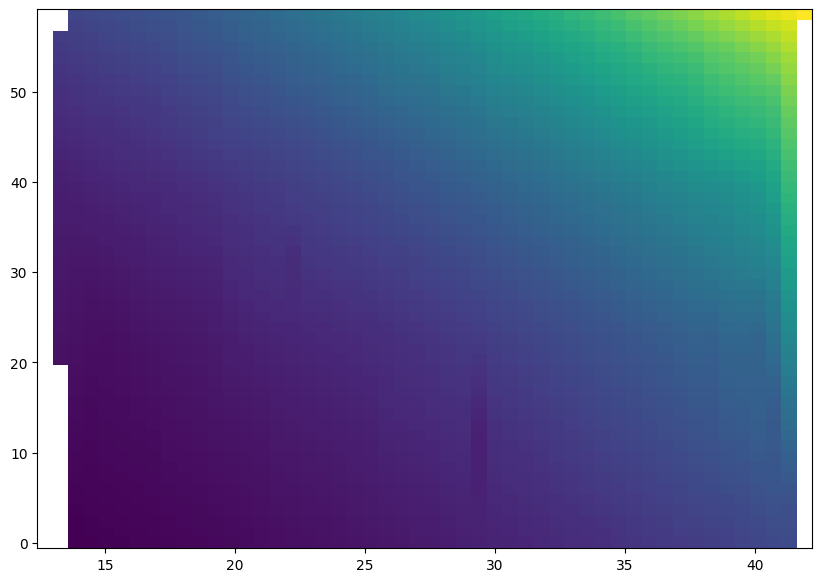

In [38]:
# 2D surface
compound_filter = (df['compound'] == 'ocm')
# |(df['compound'] == 'butanol')
data = df[compound_filter]

xy= data[['Temperature','w']]
z= data['D']
X = np.linspace(min(xy['Temperature']),max(xy['Temperature']))
Y = np.linspace(min(xy['w']),max(xy['w']))
X ,Y= np.meshgrid(X, Y)
f = LinearNDInterpolator(xy,z)
Z = f(X,Y)
plt.pcolormesh(X, Y, Z)

In [82]:
# D-T plots
name = 'PETA'
# +' + Butanol-1'

compound_filter = (
    (df['compound'] == 'peta')
    # |(df['compound'] == 'butanol')
) #yapf: disable

# Plot
data = df[compound_filter]
grouped = data.groupby(by=['w'])
colors_list = mcp.gen_color(cmap="turbo", n=len(grouped))

fig, ax = plt.subplots()
for _, group in grouped:
    w = group['w'].mean()
    T = group['Temperature']
    color = colors_list.pop()

    D = group['D'] / D_mean
    # ax.scatter(
    #     T,
    #     D,
    #     c=color,
    #     s=2,
    # )

    E = group['E'].mean()
    D0 = group['D0'].mean() / D_mean
    D_ols = D0 * np.exp(-E / (8.314 * (T+273.15)))
    ax.plot(
        T,
        D_ols,
        label=f"{w: 5.2f}",
        c=color,
    )

    ax.set_title(f"{name}: Diffusion - T")
    ax.set_xlabel('Temperature [C]')
    ax.set_ylabel('D/D0')
plt.legend()

In [94]:
# D-fi plots
name = 'PETA'
# +' + Butanol-1'

compound_filter = (
    (df['compound'] == 'peta')
    # |(df['compound'] == 'butanol')
) #yapf: disable

# Plot
data = df[compound_filter]
temper_list = np.arange(15,41,5)
colors_list = mcp.gen_color(cmap="turbo", n=len(temper_list))

fig, ax = plt.subplots()
for T in temper_list:
    cond = (data['Temperature']>=T-1)&(data['Temperature']<=T+1)
    group=data[cond]
    group=group[['w','D']].groupby(by='w').mean().reset_index()
    
    w = group['w']
    color = colors_list.pop()

    D = group['D'] / D_mean
    ax.plot(
        w,
        D,
        c=color,
        # s=5,
        label=f"{T: 3.0f}",
    )

    ax.set_title(f"{name}: Diffusion - fi")
    ax.set_xlabel('fi [%]')
    ax.set_ylabel('D/D0')
plt.legend()

In [83]:
# E plots
data=df.copy(deep=True)
tmp= data[data['compound']=='butanol']
data['compound']=data['compound'].replace({'butanol':'ocm'})
tmp['compound']='peta'
data=pd.concat([data,tmp])

grouped = data.groupby(by=['compound'])
fig, ax = plt.subplots()

for _, group in grouped:
    name= group['compound'].unique()[0]
    group=group[['E','w']].groupby(by=['w']).mean().reset_index()
    w = group['w']
    E = group['E']/1000
    ax.plot(
        [w.iloc[0],w.iloc[-1]],
        [E.iloc[0],E.iloc[-1]],
        # label=f"{name}",
    )
    ax.scatter(
        w,
        E,
        label=f"{name}",
    )

    ax.set_title(f"E - fi")
    ax.set_xlabel('fi [%]')
    ax.set_ylabel('E [kJ]')
plt.legend()

In [88]:
data=df.copy(deep=True)
tmp= data[data['compound']=='butanol']
data['compound']=data['compound'].replace({'butanol':'ocm'})
tmp['compound']='peta'
data=pd.concat([data,tmp])

grouped = data.groupby(by=['compound'])
fig, ax = plt.subplots()

for _, group in grouped:
    name= group['compound'].unique()[0]
    group=group[['rho','w']].groupby(by=['w']).mean().reset_index()
    w = group['w']
    E = group['rho']
    # ax.plot(
    #     [w.iloc[0],w.iloc[-1]],
    #     [E.iloc[0],E.iloc[-1]],
    #     # label=f"{name}",
    # )
    ax.scatter(
        w,
        E,
        label=f"{name}",
    )

    ax.set_title(f"rho - fi")
    ax.set_xlabel('fi [%]')
    ax.set_ylabel('rho [g/ml]')
plt.legend()

# 3D

In [6]:
fig = go.Figure()
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0, pad=0),
    scene=dict(
        xaxis=dict(title='Temperature [C]'),
        yaxis=dict(title='fi [%]'),
        zaxis=dict(title='Diffusion'), 
    ))
quality=21

# OCM
compound_filter = (df['compound'] == 'ocm') 
# |(df['compound'] == 'butanol')

data = df[compound_filter]
xy = data[['Temperature', 'w']]
x = data['Temperature']
y = data['w']
z = data['D'] / D_mean


f = LinearNDInterpolator(xy, z)

x1 = np.linspace(x.min(), x.max(), quality)
y1 = np.linspace(y.min(), y.max(), quality)
X, Y = np.meshgrid(x1, y1)

Z = f(X,Y)
R = Z
fig.add_trace(go.Surface(
    name='OCM-2',
    x=x1,
    y=y1,
    z=Z,
    colorscale='Reds',
    surfacecolor=R,
    showscale=False,
    showlegend=True,
    opacity=0.7,
    lightposition=dict(x=50, y=100, z=1.),
))

# PETA
compound_filter = (df['compound'] == 'peta') 
# |(df['compound'] == 'butanol')
data = df[compound_filter]

xy = data[['Temperature', 'w']]
x = data['Temperature']
y = data['w']
z =  data['D'] / D_mean

fz = CloughTocher2DInterpolator(xy, z)

x1 = np.linspace(x.min(), x.max(), quality)
y1 = np.linspace(y.min(), y.max(), quality)
X, Y = np.meshgrid(x1, y1)


Z = fz(X, Y)

fig.add_trace(go.Surface(
    name='PETA',
    x=x1,
    y=y1,
    z=Z,
    colorscale='Blues',
    surfacecolor=-R,
    showscale=False,
    showlegend=True,
    lightposition=dict(x=50, y=100, z=1.),
    
))
fig.show()

## Plots

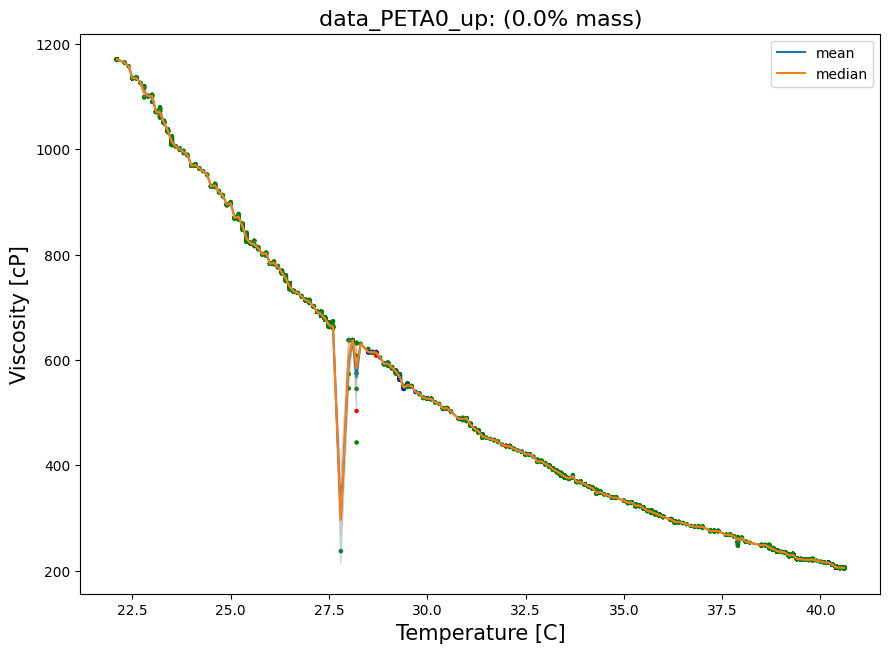

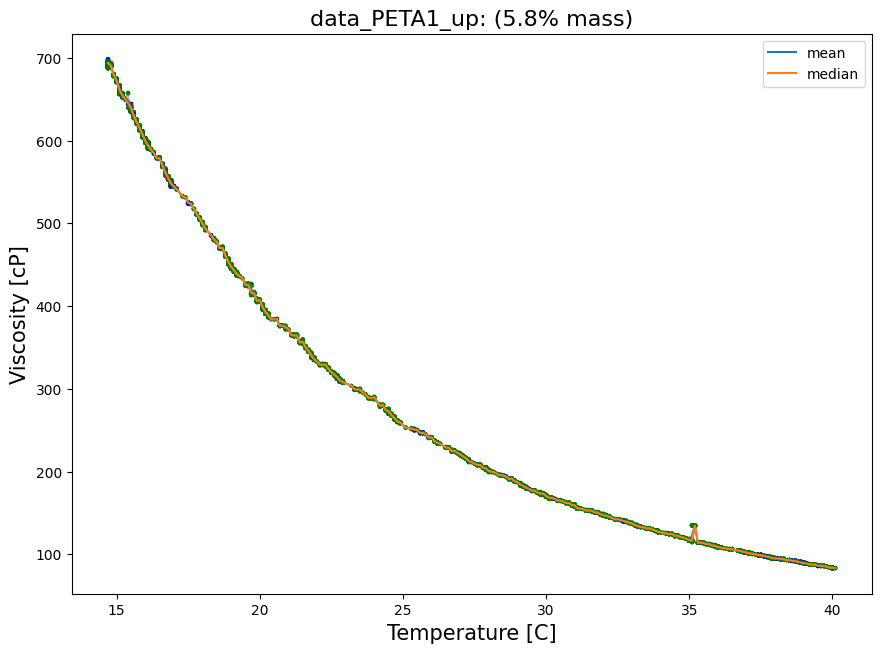

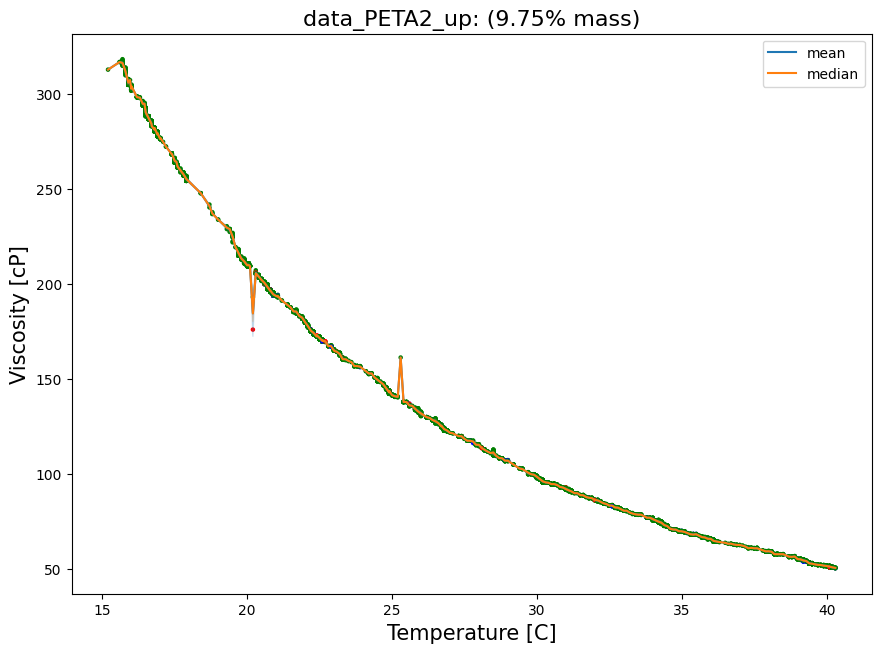

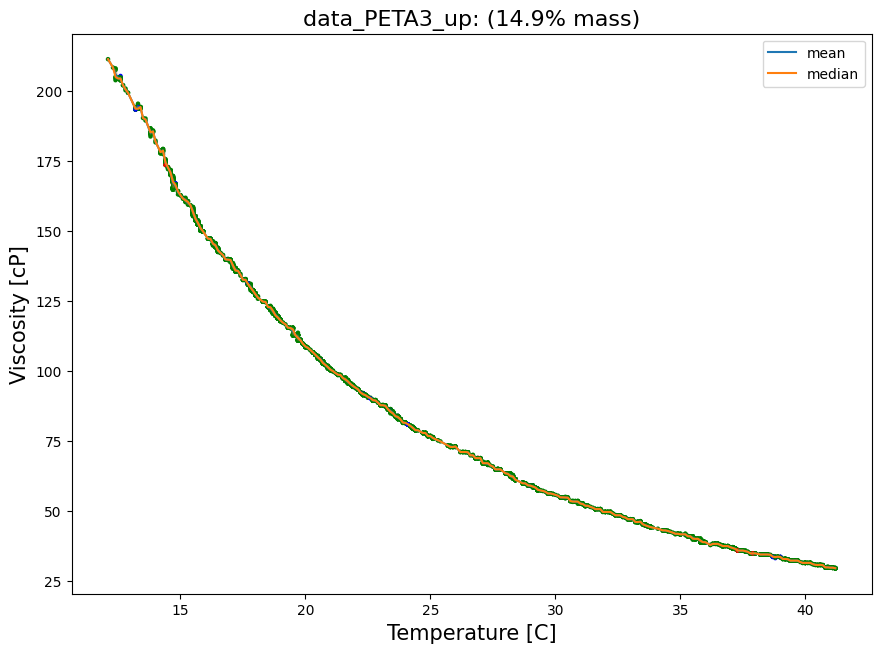

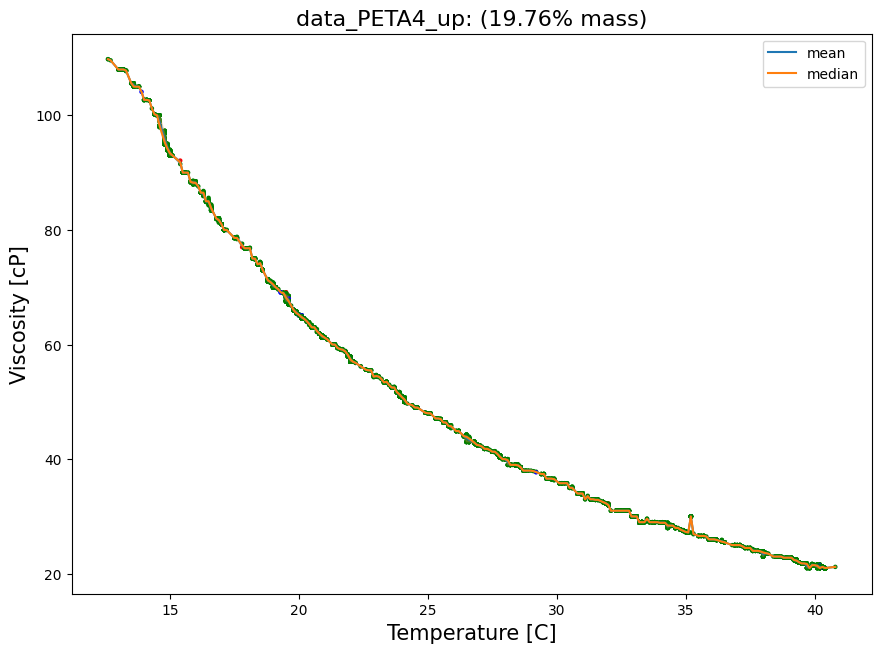

In [12]:
folders = [f'{PATH}\{i}' for i in os.listdir(PATH) if os.path.isdir(f'{PATH}\{i}') and 'PETA' in i]
for folder in folders:

    exp = Experiment()
    file = [file for file in os.listdir(folder) if '.hdf5' in file][0]
    exp.load_hdf5(input_path(f'{folder}\{file}'))
    exp.apply(funcs.C_to_K)
    exp.apply(funcs.nu_D)
    exp.apply(funcs.K_to_C)
    # exp.folder='.'
    plots.temperature_plot(
        exp,
        title='Temperature',
        xlabel='Temperature [C]',
        ylabel='Viscosity [cP]',
        # ylabel='Diffusion [m2/s]',
        interactive=True,
        save_folder=exp.folder,
    )

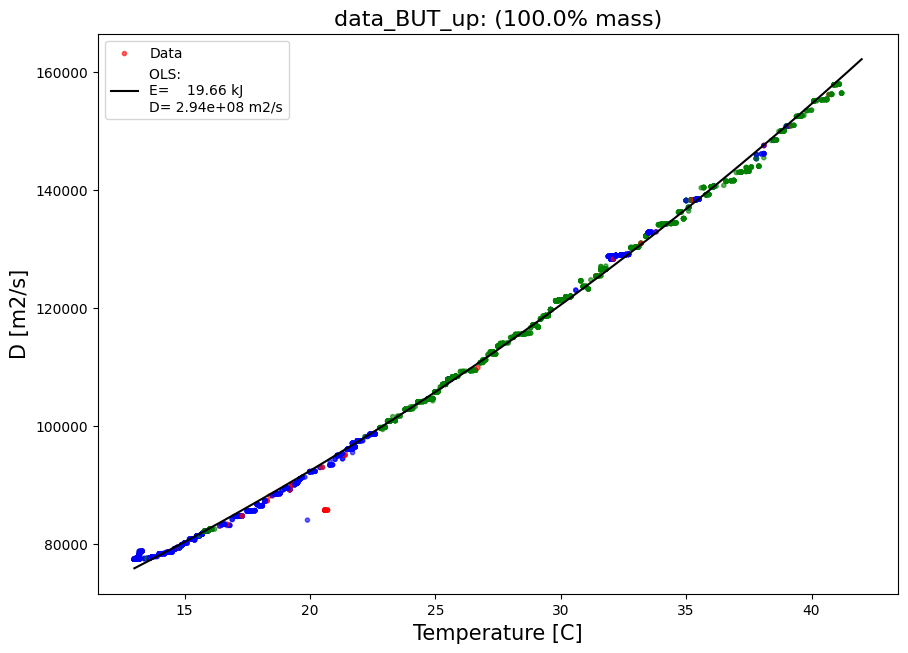

In [6]:
exp = Experiment()
exp.load_hdf5(input_path())
# exp.apply(funcs.C_to_K)
# exp.apply(funcs.nu_D)
# exp.apply(funcs.K_to_C)

info, result, func = tools.regress(exp)
exp.set_info(**info)
x = np.linspace(13, 42, 100) + 273.15
ols_res = tools.Experiment(
    pd.DataFrame({
        'x': x, 'y': func(x), 'time': x * 0
    }),
    'interpolated',
)

ols_res.apply(funcs.K_to_C)

plots.comparation_plot(
    exp,
    ols_res,
    title='OLS_Diffusion',
    xlabel='Temperature [C]',
    ylabel='D [m2/s]',
    interactive=True,
    save_folder=exp.folder,
)
# plots.temperature_plot(
#     exp,
#     title='Viscosity',
#     xlabel='Temperature [C]',
#     ylabel='Viscosity [cP]',
#     # ylabel='Diffusion [m2/s]',
#     interactive=True,
#     save_folder=exp.folder,
# )